In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import joblib  # Import for saving models

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")





In [2]:
# Load dataset
data = pd.read_csv("C:/Users/OHR.ADMIN1/Desktop/data/RAW-DATA.csv")  # Replace with your path
#data = pd.read_csv("C:/Users/Mmad/Desktop/FXPRSIG/New folder/DATA/H30-SIG-OVERAL.csv")  # Replace with your path

# Preprocessing
scaler = StandardScaler()
X = data.drop(columns=['ACT'])
y = data['ACT']  # Dependent variable (1 or 0)

# ALL DATA OR PART OF IT
X = X[:]
y = y[:]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1. Handle Class Imbalance with Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# 2. Handle Class Imbalance using SMOTE (Oversampling the Minority Class)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)



In [3]:
# Define models and parameters for GridSearchCV
models = {
    'LogisticRegression': (LogisticRegression(max_iter=500, class_weight='balanced'),
                           {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear', 'saga']}),  
    'SVM': (SVC(class_weight='balanced'), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}), 
    'KNeighbors': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9]}),
    #'RandomForest': (RandomForestClassifier(class_weight='balanced'), 
    #                 {'n_estimators': [100, 200], 'max_depth': [5, 10, 20]}),
    'DecisionTree': (DecisionTreeClassifier(class_weight='balanced'), {'max_depth': [5, 10, 20]}),
    'GradientBoosting': (GradientBoostingClassifier(), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
    #'XGBoost': (XGBClassifier(scale_pos_weight=class_weights[0] / class_weights[1]), 
    #            {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
    'MLP': (MLPClassifier(max_iter=500), {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh']})
}



In [4]:
# 3. Change Evaluation Metrics to F1-Score to Handle Imbalance
best_models = {}
for model_name, (model, params) in models.items():
    grid = GridSearchCV(model, param_grid=params, scoring='f1', cv=5)  # Use F1-score for imbalanced data
    grid.fit(X_train_res, y_train_res)  # Train with oversampled data (SMOTE)
    best_model = grid.best_estimator_
    best_models[model_name] = best_model
    
    # Save the best model using joblib
    joblib.dump(best_model, f'{model_name}_best_model.pkl')
    
    print(f"{model_name} best parameters: {grid.best_params_}")



LogisticRegression best parameters: {'C': 0.1, 'solver': 'liblinear'}
SVM best parameters: {'C': 10, 'kernel': 'rbf'}
KNeighbors best parameters: {'n_neighbors': 3}
DecisionTree best parameters: {'max_depth': 20}
GradientBoosting best parameters: {'learning_rate': 0.1, 'n_estimators': 200}
MLP best parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50)}


In [5]:
# Evaluate the best models on the test set
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))




LogisticRegression Results:
Accuracy: 0.6345
F1-Score: 0.3533
Confusion Matrix:
[[6694 3549]
 [1028 1250]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.65      0.75     10243
           1       0.26      0.55      0.35      2278

    accuracy                           0.63     12521
   macro avg       0.56      0.60      0.55     12521
weighted avg       0.76      0.63      0.67     12521


SVM Results:
Accuracy: 0.6694
F1-Score: 0.3695
Confusion Matrix:
[[7168 3075]
 [1065 1213]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.70      0.78     10243
           1       0.28      0.53      0.37      2278

    accuracy                           0.67     12521
   macro avg       0.58      0.62      0.57     12521
weighted avg       0.76      0.67      0.70     12521


KNeighbors Results:
Accuracy: 0.6861
F1-Score: 0.3624
Confusion Matrix:
[[7474 2769]
 [1161 1117]]

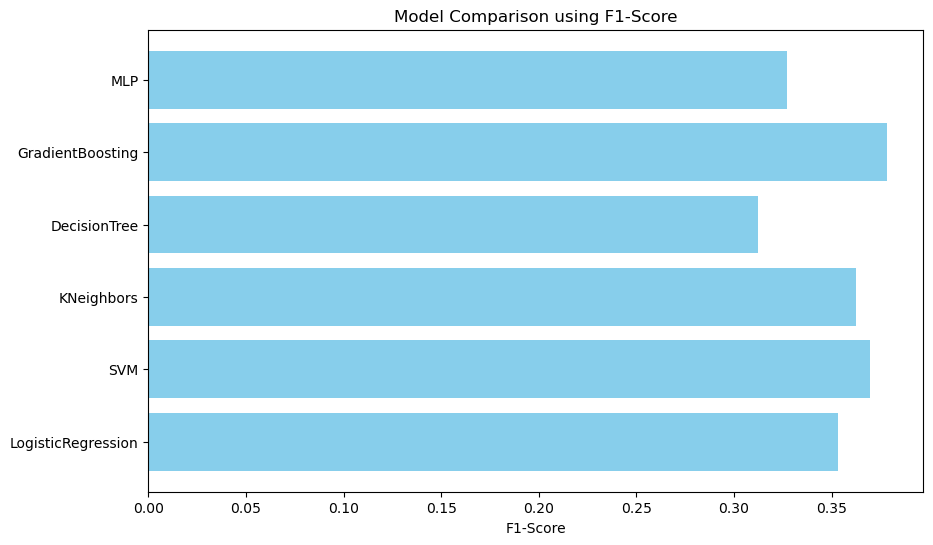

ENDING NOW


In [6]:
# Plot comparison of model performance using F1-score
f1_scores = [f1_score(y_test, model.predict(X_test)) for model in best_models.values()]
model_names = list(best_models.keys())
plt.figure(figsize=(10, 6))
plt.barh(model_names, f1_scores, color='skyblue')
plt.xlabel('F1-Score')
plt.title('Model Comparison using F1-Score')
plt.show()

print('ENDING NOW')


In [8]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# Lists to store metrics
model_names = list(best_models.keys())
f1_scores = []
accuracies = []
precisions = []
recalls = []

# Calculate metrics for each model
for model in best_models.values():
    y_pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))

# Create a DataFrame for easy visualization
results_df = pd.DataFrame({
    'Model': model_names,
    'F1 Score': f1_scores,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls
})

# Display the results
print(results_df)

                Model  F1 Score  Accuracy  Precision    Recall
0  LogisticRegression  0.353257  0.634454   0.260471  0.548727
1                 SVM  0.369479  0.669355   0.282882  0.532485
2          KNeighbors  0.362427  0.686127   0.287442  0.490342
3        DecisionTree  0.312454  0.627426   0.235190  0.465320
4    GradientBoosting  0.378107  0.644278   0.277232  0.594381
5                 MLP  0.327296  0.658893   0.255220  0.456102


### Analysis of Model Results for Forecasting Buy/Sell Signals in Gold Trading

In this analysis, we evaluated the performance of six different machine learning models—Logistic Regression, Support Vector Machine (SVM), K-Neighbors, Decision Tree, Gradient Boosting, and Multi-Layer Perceptron (MLP)—using a dataset with 52 technical indicators to predict buy/sell signals for gold in the forex market.

#### Overview of Performance Metrics

| Model               | F1 Score | Accuracy | Precision | Recall  |
|---------------------|----------|----------|-----------|---------|
| Logistic Regression  | 0.3533   | 0.6345   | 0.2605    | 0.5487  |
| SVM                  | 0.3695   | 0.6694   | 0.2829    | 0.5325  |
| K-Neighbors          | 0.3624   | 0.6861   | 0.2874    | 0.4903  |
| Decision Tree        | 0.3125   | 0.6274   | 0.2352    | 0.4653  |
| Gradient Boosting    | 0.3781   | 0.6443   | 0.2772    | 0.5944  |
| MLP                  | 0.3273   | 0.6589   | 0.2552    | 0.4561  |

### Key Observations

1. **Best Performing Model**: 
   - **Gradient Boosting** achieved the highest F1 score (0.3781) and a respectable accuracy of 0.6443. This indicates its capability to balance precision and recall better than the other models, particularly in identifying the minority class (buy/sell signal).

2. **SVM and K-Neighbors**:
   - Both models performed similarly, with SVM yielding an accuracy of 0.6694 and F1 score of 0.3695. K-Neighbors followed closely with an accuracy of 0.6861 but had a lower F1 score (0.3624), indicating that while it is accurate, it struggles more with balancing precision and recall for the minority class.

3. **Logistic Regression**:
   - This model displayed a lower performance across all metrics (F1 score of 0.3533, accuracy of 0.6345). Its precision (0.2605) highlights a tendency to misclassify positive instances, as it identifies fewer true positive signals compared to false positives.

4. **Decision Tree**:
   - The Decision Tree model had the lowest F1 score (0.3125) and accuracy (0.6274), suggesting overfitting or poor generalization on unseen data. Its precision was the lowest among all models (0.2352), indicating that it struggles significantly with identifying the correct buy/sell signals.

5. **Multi-Layer Perceptron (MLP)**:
   - The MLP model performed moderately with an accuracy of 0.6589 and an F1 score of 0.3273. While it showed some capability, its precision (0.2552) and recall (0.4561) suggest a need for further tuning and optimization.

### Conclusion

The evaluation highlights the varying effectiveness of different models in predicting buy/sell signals for gold trading. Gradient Boosting stands out as the most balanced and effective model among those tested, while the Decision Tree performed the least effectively. 

Future efforts should focus on hyperparameter tuning, feature engineering, and potentially using ensemble methods to further enhance model performance. Additionally, investigating the reasons behind the lower precision and recall for some models could provide insights into how to improve the classification of minority classes. This analysis underscores the importance of selecting the right model and metrics tailored to the specific challenges of forecasting in financial markets.